In [1]:
# =============================================================
# 0. 환경 설정
# =============================================================
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt


In [2]:

# -------------------------------------------------------------
# 1. Load FE dataset
# -------------------------------------------------------------
FE_PATH = "../../notebooks/preprocessing/fe_v1.csv"
fe_df = pd.read_csv(FE_PATH)
print("FE loaded:", fe_df.shape)



FE loaded: (42000, 17)


In [3]:
# -------------------------------------------------------------
# 2. Train/Valid split by time t
# -------------------------------------------------------------
train_df = fe_df[fe_df["t"] <= 36]
valid_df = fe_df[fe_df["t"] > 36]

drop_cols = ["target", "leader", "follower"]

X_train = train_df.drop(columns=drop_cols)
y_train = train_df["target"]

X_valid = valid_df.drop(columns=drop_cols)
y_valid = valid_df["target"]

print("Train:", X_train.shape, "Valid:", X_valid.shape)



Train: (36000, 14) Valid: (6000, 14)


In [4]:
# -------------------------------------------------------------
# 3. LightGBM 모델 설정
# -------------------------------------------------------------
model = lgb.LGBMRegressor(
    objective="regression",
    metric="rmse",
    n_estimators=5000,
    learning_rate=0.015,
    
    num_leaves=127,
    max_depth=-1,

    subsample=0.7,
    colsample_bytree=0.7,

    reg_alpha=1.0,
    reg_lambda=1.0,

    min_child_samples=20,
    min_split_gain=0
)

model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(stopping_rounds=200)]
)




[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2440
[LightGBM] [Info] Number of data points in the train set: 36000, number of used features: 14
[LightGBM] [Info] Start training from score 4429696.996222
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[106]	valid_0's rmse: 3.46946e+06


,boosting_type,'gbdt'
,num_leaves,127
,max_depth,-1
,learning_rate,0.015
,n_estimators,5000
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0
,min_child_weight,0.001
,min_child_samples,20


In [5]:
# -------------------------------------------------------------
# 4. Validation RMSE
# -------------------------------------------------------------
pred = model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, pred))
print("VALID RMSE:", rmse)


VALID RMSE: 3469456.5043019396


<Figure size 800x1200 with 0 Axes>

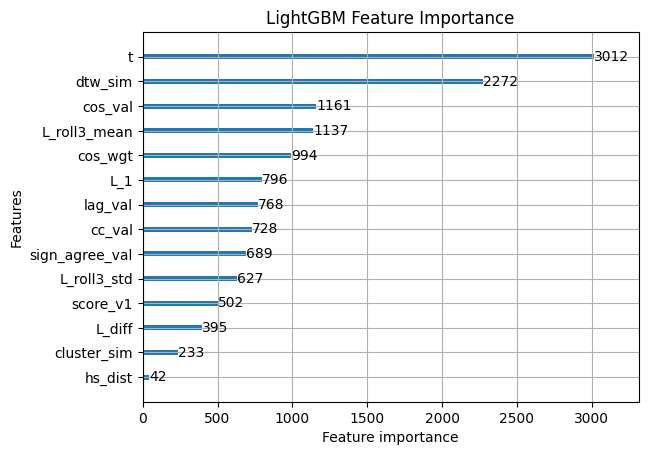

In [6]:

# -------------------------------------------------------------
# 5. Feature Importance 시각화
# -------------------------------------------------------------
plt.figure(figsize=(8, 12))
lgb.plot_importance(model, max_num_features=25)
plt.title("LightGBM Feature Importance")
plt.show()


In [7]:
# -------------------------------------------------------------
# 6. Inference (t == 42)
# -------------------------------------------------------------
test_df = fe_df[fe_df["t"] == 42].drop(columns=drop_cols)
test_pred = model.predict(test_df)

print("test_pred shape:", test_pred.shape)


test_pred shape: (1000,)


In [8]:
print(type(test_pred))        # numpy.ndarray
print(test_pred.ndim)         # 1
print(test_pred[:10])         # 앞에 10개 미리보기


<class 'numpy.ndarray'>
1
[2064806.09467457  944683.60693104  944683.60693104  962034.20606176
  962034.20606176 1053099.70105691  948125.75303841  962034.20606176
 1098239.6274235  1246037.95660323]


In [9]:
print("train_df shape:", train_df.shape)
print("valid_df shape:", valid_df.shape)
print("train_df t-range:", train_df["t"].min(), "~", train_df["t"].max())
print("valid_df t-range:", valid_df["t"].min(), "~", valid_df["t"].max())


train_df shape: (36000, 17)
valid_df shape: (6000, 17)
train_df t-range: 1 ~ 36
valid_df t-range: 37 ~ 42


In [10]:
# -------------------------------------------------------------
# 7. sample_submission 생성
# -------------------------------------------------------------
sample = pd.read_csv("../../data/raw/sample_submission.csv")
direction_df = pd.read_csv("../../notebooks/preprocessing/direction_df_top1000.csv")

# 1) direction_df 정렬 (fe 생성 시 순서와 맞추기)
direction_df_sorted = direction_df.sort_values(["leader", "follower"]).reset_index(drop=True)

# 2) test_pred 매핑
direction_df_sorted["pred_value"] = test_pred

# 3) sample_submission과 merge
sub = sample.merge(
    direction_df_sorted[["leader", "follower", "pred_value"]],
    left_on=["leading_item_id", "following_item_id"],
    right_on=["leader", "follower"],
    how="left"
)

# 4) value 생성
# 공행성쌍에 없는 경우 → 0
sub["value"] = sub["pred_value"].fillna(0)
sub["value"] = sub["value"].round().astype(int)

# 5) 최종 컬럼 정리
sub = sub[["leading_item_id", "following_item_id", "value"]]

# -------------------------------------------------------------
# 8. Save submission
# -------------------------------------------------------------
sub.to_csv("submission_gbdt_v4.1.csv", index=False)
print("Saved: submission_gbdt_v4.1.csv")

Saved: submission_gbdt_v4.1.csv
